In [3]:
!pip install captum

  Using cached captum-0.8.0-py3-none-any.whl.metadata (26 kB)
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached captum-0.8.0-py3-none-any.whl (1.4 MB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


In [4]:
#load packages
import numpy as np
import zipfile
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.patches import Patch

import captum
from captum.attr import Occlusion, Saliency
from captum.attr import visualization as viz


from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader, Subset

# Unzip data folder
zip_path = "problem3.zip" 
extract_path = "problem3" 
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [5]:
# Define the path to your root directory
data_path = "./problem3/problem2/train"

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # size needed for resnet18
    transforms.ToTensor()
])

# Load the dataset
dataset = datasets.ImageFolder(root=data_path, transform=transform)


In [6]:
dataset.class_to_idx

{'restriction signs': 0,
 'speed limits': 1,
 'stop signs': 2,
 'warning signs': 3,
 'yield signs': 4}

In [7]:
class_indices = defaultdict(list)
for idx, (_, label) in enumerate(dataset.samples):
    class_indices[label].append(idx)

# Split each class into train/val
train_indices = []
val_indices = []

for label, indices in class_indices.items():
    split = int(0.8 * len(indices)) #split 80/20
    train_indices += indices[:split]
    val_indices += indices[split:]

# 6. Create Subsets and DataLoaders
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
#use the torchvision model

model = models.resnet18(weights=None)

num_classes = len(dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes) #change number of outputs

model = model.to(device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
def accuracy(soft_pred, target):
    """The number of correct predictions divided by the number of total predictions."""
    return (soft_pred.argmax(dim=1) == target).float().mean()

In [11]:
def train_one_epoch(model, dataloader):

    # Set model in training mode
    
    model.train()
    train_loss = 0
    train_acc = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
         # Zero the gradients from last gradient update (otherwise they accumulate)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        # Compute loss
        loss = loss_function(outputs, labels)
        acc = accuracy(outputs, labels)
        # Backward pass
        loss.backward()
        optimizer.step()
        # Update statistics
        train_acc +=  acc
        train_loss += loss.item()
        
    # Compute average loss and accuracy
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc

In [12]:
def confusion_matrix(soft_pred, target):
    """Compute the confusion matrix. Rows represent the true class, columns represent the predicted class.
    This can be useful for understanding which classes are being confused."""
    num_samples = soft_pred.shape[0]
    num_classes = soft_pred.shape[1]
    confusion_matrix = torch.zeros(num_classes, num_classes)
    predicted = soft_pred.argmax(1)
    for i in range(num_samples):
        confusion_matrix[target[i], predicted[i]] += 1
    return confusion_matrix

In [13]:
def plot_confusion_matrix(cm, path=None):
    """Plots the confusion matrix and saves the plot"""
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(cm, cmap="Blues")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(i, j, f"{cm[j, i]:.0f}", ha="center", va="center")

    plt.xlabel("Predicted label")
    plt.ylabel("True label")

    plt.xticks(range(5))
    plt.yticks(range(5))
    plt.tight_layout()
    if path:
        plt.savefig(path)
    plt.show()

In [14]:
def evaluate(model, dataloader):
    ## Set model to evaluation mode (important for dropout and batch normalization layers)
    model.eval()
    val_loss = 0
    val_acc = 0
    ## Initialize confusion matrix
    con_mat_track = torch.zeros(5, 5)
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            
            ## Move data to device 
            inputs, labels = inputs.to(device), labels.to(device)
            
            ## Forward pass
            outputs = model(inputs)

            ##Compute loss
            loss = loss_function(outputs, labels)   

            ## Compute metric
            acc = accuracy(outputs, labels)
            con_mat = confusion_matrix(outputs, labels)

            ## Update statistics
            val_loss += loss.item()
            val_acc += acc
            con_mat_track += con_mat

    ## Compute average loss and accuracy 
    val_loss /= len(dataloader)
    val_acc /= len(dataloader)

    
    
    return val_loss, val_acc, con_mat_track

In [15]:
# Loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training loop with early stopping
early_stop_patience = 5
best_val_loss = float('inf')
patience_counter = 0

report_template = "Epoch {}: Train loss = {:.4f}, Train acc = {:.4f} | Val loss = {:.4f}, val acc = {:.4f}"

for epoch in range(50):

    train_loss, train_acc = train_one_epoch(model, train_loader)

    val_loss, val_acc, con_mat = evaluate(model, val_loader)


    print(report_template.format(epoch, train_loss, train_acc, val_loss, val_acc))

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break

In [16]:
#load the best model
model.load_state_dict(torch.load("best_model.pth", weights_only=True))

<All keys matched successfully>

After training: Val loss = 0.0360, Val accuracy = 0.9891
Confusion matrix:


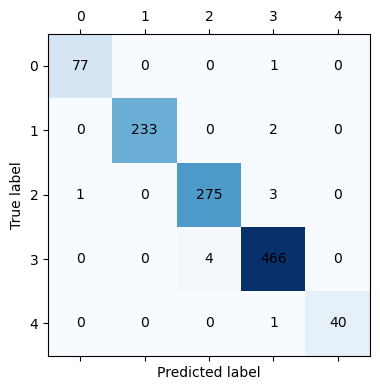

In [17]:
## Evaluate the model on the validation set
val_loss, val_acc, con_mat = evaluate(model.to(device), val_loader)
print(f"After training: Val loss = {val_loss:.4f}, Val accuracy = {val_acc:.4f}")
print("Confusion matrix:")
plot_confusion_matrix(con_mat, "./conf_map_val_1.png")

In [18]:
#load the test set

data_path = "./problem3/problem2/test"
test_dataset = datasets.ImageFolder(root=data_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)

Test loss = 0.9720, Test acc = 0.7898


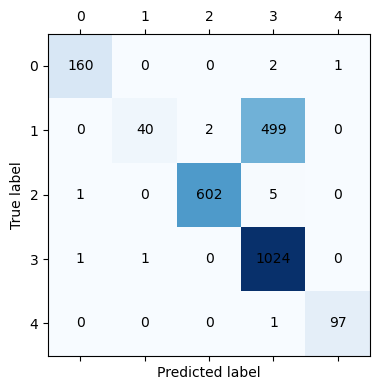

In [19]:
#evaluate the model on the test set

test_loss, test_acc, test_con_mat = evaluate(model.to(device), test_loader)
print(f"Test loss = {test_loss:.4f}, Test acc = {test_acc:.4f}")
plot_confusion_matrix(test_con_mat, "./conf_map_test_1.png" )

In [20]:
def plot_prediction_real_images(dataloader, model, prediction, real_label, path = None):
    "prints 10 images of class 'real_label' classified as 'prediction', returns the 10 images in a dataset to use later in the saliency maps"
    model.eval()
    shown = 0
    #initialize the images tensor
    selected_images = torch.Tensor()

    with torch.no_grad():
        for inputs, labels in dataloader:

            #move to device
            inputs, labels = inputs.to(device), labels.to(device)
            #forward pass
            outputs = model(inputs)
            #find final prediction and choose only the pictures with the requested label and prediction
            preds = outputs.argmax(dim=1)
            wrong_mask = (preds == prediction) & (labels == real_label)

            #store the wanted data
            wrong_inputs = inputs[wrong_mask]
            wrong_preds = preds[wrong_mask]
            wrong_labels = labels[wrong_mask]

            #save the wanted pictures
            selected_images = torch.cat((selected_images,inputs[wrong_mask].detach().cpu()),0)
            
            for image, pred, label in zip(wrong_inputs, wrong_preds, wrong_labels):
                
                #plot the images
                #selected_images = torch.stack((selected_images,image.detach().cpu()))
                plt.subplot(2, 5, shown + 1)
                plt.imshow(np.transpose(image.detach().cpu().numpy(), (1, 2, 0)))
                plt.title(f'Pred: {pred.item()}, True: {label.item()}' , fontsize=10)
                plt.axis('off')
                shown += 1
                if shown >= 10:
                    plt.tight_layout()
                    if path:
                        plt.savefig(path)
                    plt.show()
                    return TensorDataset(selected_images[:10], torch.full((10,), real_label))

    
        #return the plotted images
    return TensorDataset(selected_images[:10], torch.full((10,), real_label))

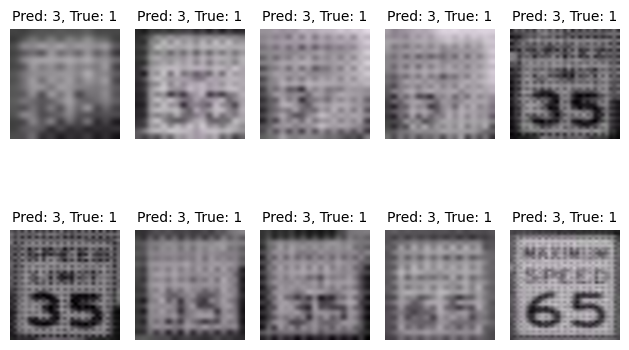

In [21]:
false_predictions31 = plot_prediction_real_images(test_loader, model.to(device), 3, 1, "./pics_31.png")

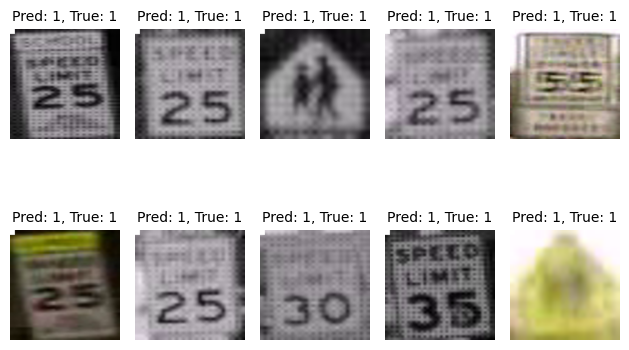

In [22]:
train_pred11 = plot_prediction_real_images(train_loader, model.to(device), 1, 1, "./pics_11.png")

In [23]:


def sal_map(model, dataloader, device, path=None):
    """prints the saliency map for the dataloader and saves the picture if path is present"""
    
    model.eval()
    #use Saliency from Captumu
    saliency = Saliency(model)
    shown = 0
    
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        #need gradient to find saliency
        inputs.requires_grad_()

        # Get saliency attributions from Captum
        attributions = saliency.attribute(inputs, target=labels, abs=True)
        # Convert to saliency map: absolute value + max over channels
        sal_maps = attributions.detach().cpu().max(dim=1)[0]

        for idx in range(inputs.size(0)):
            if shown == 10:
                break
            #save the data to plot
            img = inputs[idx].detach().cpu().numpy().transpose(1, 2, 0)
            sal = sal_maps[idx].numpy()
            pred = model(inputs)[idx].argmax().item()
            label = labels[idx].item()

            plt.subplot(2, 5, shown + 1)
            plt.imshow(img, alpha=1)
            im = plt.imshow(sal, cmap='cool', alpha=0.8)
            plt.title(f'Pred: {pred}, True: {label}' , fontsize=10)
            plt.axis('off')
            shown += 1

        if shown == 10:
            plt.tight_layout()
            plt.colorbar(im, ax=plt.gcf().axes, fraction=0.02, pad=0.04, label='Saliency intensity')
            if path:
                plt.savefig(path)
            plt.show()
            return
    return


In [51]:
train_img1 = torch.Tensor()
# save ten images from class 1 in the training set
for inputs, labels in train_loader:
    train_img1 = torch.cat((train_img1, inputs[labels == 1]),0)
    if (train_img1.size(0)>9):
        train_img1 = train_img1[:10]
        break


    

In [26]:
labels_img1 = torch.ones(10, dtype=torch.long)

img1_dataset = TensorDataset(train_img1, labels_img1)
#build the dataloader
img1_loader = DataLoader(img1_dataset, batch_size=2, shuffle=False, num_workers=2)

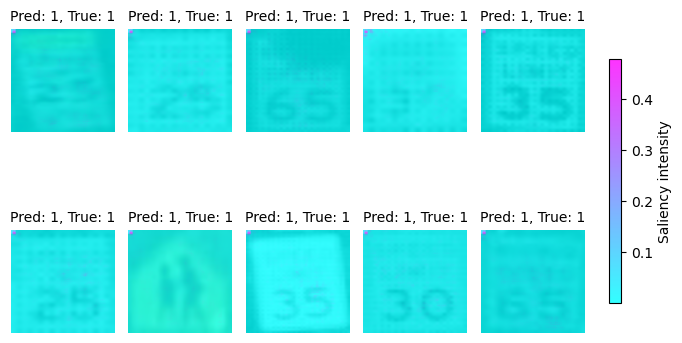

In [27]:
#plot the saliency map for the ten images 
sal_map(model, img1_loader, device, "./sal_maps_1.png")

In [28]:


def occlusion_map(model, dataloader, device, path = None):
    """prints the occlusion analisys for the dataloader and saves the picture if path is present"""
    model.eval()
    #use Occlusion from Captum
    occlusion = Occlusion(model)
    shown = 0

    with torch.inference_mode():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Compute occlusion attributions
            attributions = occlusion.attribute(
                inputs,
                strides=(3, 10, 10),
                target=labels,
                sliding_window_shapes=(3, 10, 10),
                baselines=0,
                show_progress=True
            )
            
            occl_maps = attributions.abs().detach().cpu().max(dim=1)[0]
    
            for idx in range(inputs.size(0)):
                
                #data and plotting
                img = inputs[idx].detach().cpu().numpy().transpose(1, 2, 0)
                occl = occl_maps[idx].numpy()
                pred = model(inputs)[idx].argmax().item()
                label = labels[idx].item()
    
                plt.subplot(2, 5, shown + 1)
                plt.imshow(img, alpha=0.6)
                plt.imshow(occl, cmap='cool', alpha=0.8)
                plt.title(f'Pred: {pred}, True: {label}')
                plt.axis('off')
                shown += 1
    
                if shown == 10:
                    plt.tight_layout()
                    if path:
                        plt.savefig(path)
                    plt.show()
                    return
    return


Occlusion attribution:   0%|          | 0/530 [00:00<?, ?it/s]

Occlusion attribution:   0%|          | 0/530 [00:00<?, ?it/s]

Occlusion attribution:   0%|          | 0/530 [00:00<?, ?it/s]

Occlusion attribution:   0%|          | 0/530 [00:00<?, ?it/s]

Occlusion attribution:   0%|          | 0/530 [00:00<?, ?it/s]

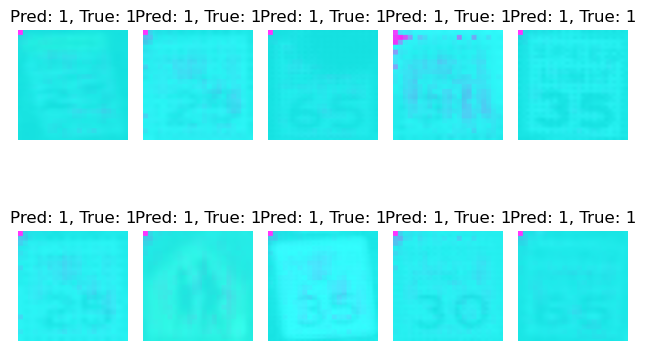

In [29]:
occlusion_map(model, img1_loader, device, "./occl_map_1.png")

In [52]:
def occlusion_pred(model, dataloader, device, path=None):
    """prints the prediction depending on occlusion area for the dataloader and saves the picture if path is present"""
    model.eval()
    shown = 0

    # Get shape of one batch
    batch_dim, channels_num, height, width = next(iter(dataloader))[0].size()

    # Occlusion patch size
    window_size = 10
    row_imag = int(height / window_size) + 1
    col_imag = int(width / window_size) + 1

    # Define color map for 5 classes
    color_map = {
        0: np.array([255, 0, 0]),      # Red
        1: np.array([0, 0, 255]),      # Blue
        2: np.array([0, 255, 0]),      # Green
        3: np.array([255, 255, 0]),    # Yellow
        4: np.array([128, 0, 128])     # Purple
    }

    # Prepare legend handles
    legend_patches = [
        Patch(color=np.array(color_map[c]) / 255.0, label=f'Class {c}')
        for c in color_map
    ]

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            batch_size = inputs.size(0)
            #initialize final image 
            final_imag = np.zeros((batch_size, row_imag, col_imag), dtype=np.uint8)


            #iterate on the positions in the final image
            for row in range(row_imag):
                for col in range(col_imag):
                    inputs_copy = inputs.clone()

                    #find where the window begins and ends
                    row_end = min(row + window_size, height)
                    col_end = min(col + window_size, width)
                    #occlude area
                    inputs_copy[:, :, row:row_end, col:col_end] = 0.0
                    #forward pass
                    outputs = model(inputs_copy)
                    #find prediction
                    pred = outputs.argmax(dim=1)
                    #insert prediction in final image
                    final_imag[:, row, col] = pred.detach().cpu().numpy()

            for idx in range(batch_size):
                #apply colours to label predicted
                rgb_map = np.zeros((row_imag, col_imag, 3), dtype=np.uint8)
                for label_val, color in color_map.items():
                    mask = final_imag[idx] == label_val
                    rgb_map[mask] = color

                # Plot with overlay and legend
                plt.subplot(2, 5, shown + 1)
                img = inputs[idx].detach().cpu().numpy().transpose(1, 2, 0)
                #img = (img - img.min()) / (img.max() - img.min())  # Normalize

                #plt.imshow(img, alpha=0.8)
                plt.imshow(rgb_map, alpha=1, interpolation='nearest')
                plt.title(f'True: {labels[idx].item()}')
                plt.axis('off')
                shown += 1

                if shown == 10:
                    plt.tight_layout(rect=[0, 0, 0.8, 1])
                    plt.legend(
                        handles=legend_patches,
                        bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,
                        title='Occlusion Prediction'
                    )
                    if path:
                        plt.savefig(path)
                    plt.show()
                    return


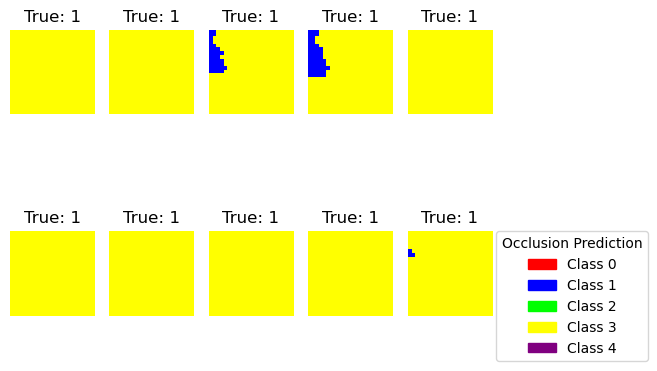

In [31]:

loader_predictions31 = DataLoader(false_predictions31, batch_size=2, shuffle=False, num_workers=2)

occlusion_pred(model, loader_predictions31, device, "occl_graph_31.png")

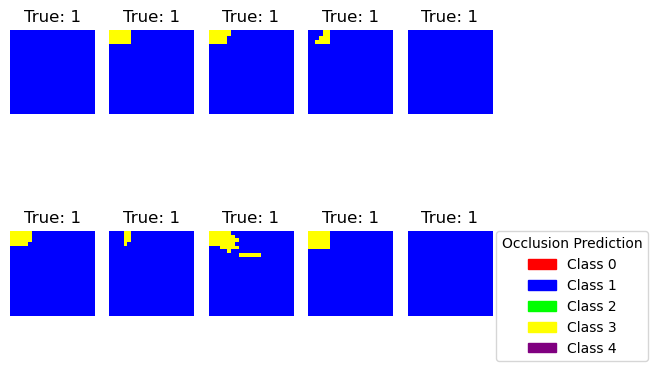

In [32]:

loader_predictions11 = DataLoader(train_pred11, batch_size=2, shuffle=False, num_workers=2)

occlusion_pred(model, loader_predictions11, device, "occl_graph_11.png")

In [33]:
data_path = "./problem3/problem2/train"

#This time we use RandomResizedCrop
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop((224, 224)),
    transforms.ToTensor(),
])

# Load the dataset
dataset_cropped = datasets.ImageFolder(root=data_path, transform=transform)

class_indices = defaultdict(list)
for idx, (_, label) in enumerate(dataset_cropped.samples):
    class_indices[label].append(idx)

# 5. Split each class into train/val
train_indices = []
val_indices = []

for label, indices in class_indices.items():
    split = int(0.8 * len(indices))
    train_indices += indices[:split]
    val_indices += indices[split:]

# 6. Create Subsets and DataLoaders
train_dataset_cropped = Subset(dataset_cropped, train_indices)
val_dataset_cropped = Subset(dataset_cropped, val_indices)

train_crop_loader = DataLoader(train_dataset_cropped, batch_size=8, shuffle=True, num_workers=4)
val_crop_loader = DataLoader(val_dataset_cropped, batch_size=8, shuffle=False, num_workers=4)

In [34]:
#restart the model

model = models.resnet18(weights=None)

num_classes = len(dataset_cropped.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [35]:
# Loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [36]:
# Training loop with early stopping
early_stop_patience = 5
best_val_loss = float('inf')
patience_counter = 0

report_template = "Epoch {}: Train loss = {:.4f}, Train acc = {:.4f} | Val loss = {:.4f}, val acc = {:.4f}"

for epoch in range(50):

    train_loss, train_acc = train_one_epoch(model, train_crop_loader)

    val_loss, val_acc, con_mat = evaluate(model, val_crop_loader)


    print(report_template.format(epoch, train_loss, train_acc, val_loss, val_acc))

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model2.pth")
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break

Epoch 0: Train loss = 1.1142, Train acc = 0.5917 | Val loss = 1.2132, val acc = 0.6830
Epoch 1: Train loss = 0.8134, Train acc = 0.7201 | Val loss = 0.6997, val acc = 0.8089
Epoch 2: Train loss = 0.6639, Train acc = 0.7752 | Val loss = 0.6662, val acc = 0.7556
Epoch 3: Train loss = 0.5448, Train acc = 0.8135 | Val loss = 0.9147, val acc = 0.6840
Epoch 4: Train loss = 0.4879, Train acc = 0.8367 | Val loss = 0.4974, val acc = 0.8443
Epoch 5: Train loss = 0.4361, Train acc = 0.8539 | Val loss = 0.5267, val acc = 0.8298
Epoch 6: Train loss = 0.4002, Train acc = 0.8598 | Val loss = 0.4431, val acc = 0.8689
Epoch 7: Train loss = 0.3619, Train acc = 0.8736 | Val loss = 0.4328, val acc = 0.8606
Epoch 8: Train loss = 0.3467, Train acc = 0.8827 | Val loss = 0.4219, val acc = 0.8370
Epoch 9: Train loss = 0.3079, Train acc = 0.8941 | Val loss = 0.4210, val acc = 0.8297
Epoch 10: Train loss = 0.3132, Train acc = 0.8947 | Val loss = 0.3412, val acc = 0.8791
Epoch 11: Train loss = 0.2688, Train acc =

In [44]:
model.load_state_dict(torch.load("best_model2.pth", weights_only=True))

<All keys matched successfully>

After training: Val loss = 0.2908, Val accuracy = 0.9020
Confusion matrix:


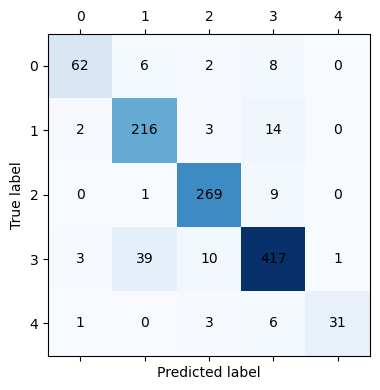

In [45]:
## Evaluate the model on the validation set
val_loss, val_acc, con_mat = evaluate(model.to(device), val_crop_loader)
print(f"After training: Val loss = {val_loss:.4f}, Val accuracy = {val_acc:.4f}")
print("Confusion matrix:")
plot_confusion_matrix(con_mat, "./val2_conf_map.png")

Test loss = 0.1504, Test acc = 0.9525


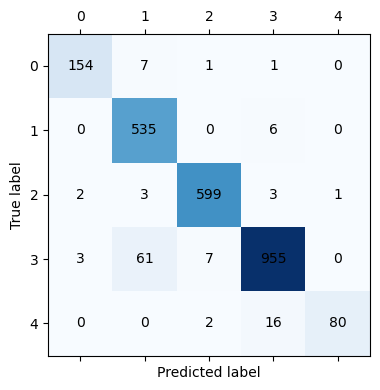

In [46]:
test_loss, test_acc, test_con_mat = evaluate(model.to(device), test_loader)
print(f"Test loss = {test_loss:.4f}, Test acc = {test_acc:.4f}")
plot_confusion_matrix(test_con_mat, "./test2_conf_map.png")

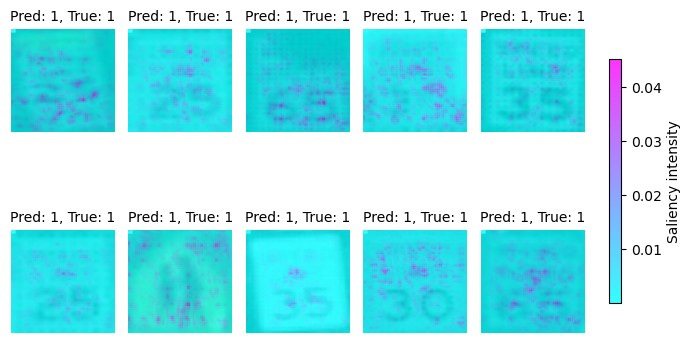

In [40]:
sal_map(model, img1_loader, device, "./sal_map2.png")

Occlusion attribution:   0%|          | 0/530 [00:00<?, ?it/s]

Occlusion attribution:   0%|          | 0/530 [00:00<?, ?it/s]

Occlusion attribution:   0%|          | 0/530 [00:00<?, ?it/s]

Occlusion attribution:   0%|          | 0/530 [00:00<?, ?it/s]

Occlusion attribution:   0%|          | 0/530 [00:00<?, ?it/s]

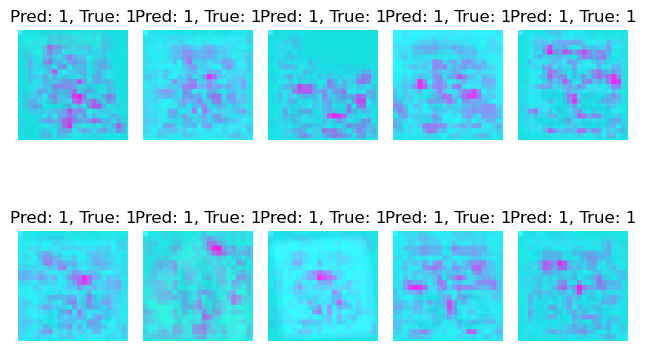

In [41]:
occlusion_map(model, img1_loader, device, "./occl_map2.png")

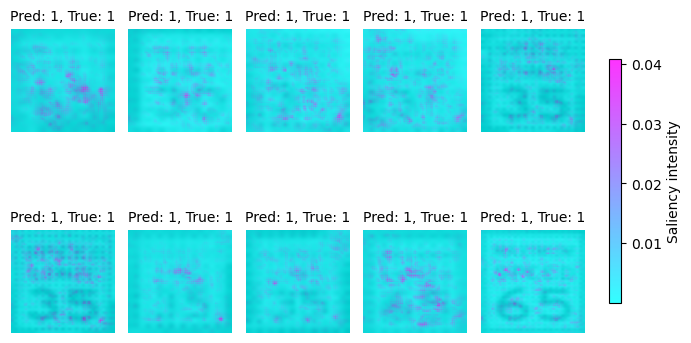

In [49]:
sal_map(model, loader_predictions31, device)

Occlusion attribution:   0%|          | 0/530 [00:00<?, ?it/s]

Occlusion attribution:   0%|          | 0/530 [00:00<?, ?it/s]

Occlusion attribution:   0%|          | 0/530 [00:00<?, ?it/s]

Occlusion attribution:   0%|          | 0/530 [00:00<?, ?it/s]

Occlusion attribution:   0%|          | 0/530 [00:00<?, ?it/s]

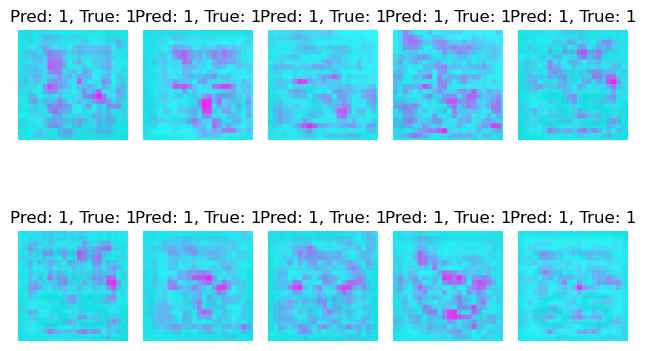

In [47]:
occlusion_map(model, loader_predictions31, device, )

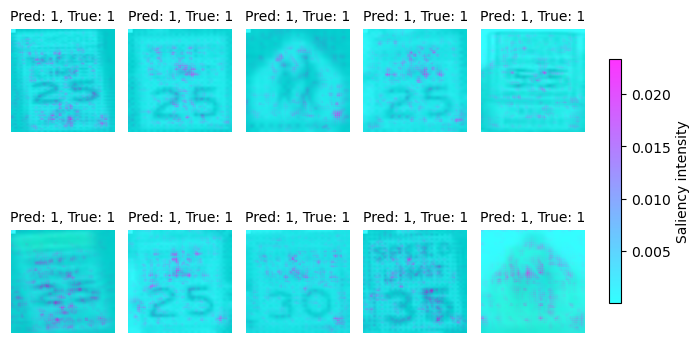

In [50]:
sal_map(model, loader_predictions11, device)

Occlusion attribution:   0%|          | 0/530 [00:00<?, ?it/s]

Occlusion attribution:   0%|          | 0/530 [00:00<?, ?it/s]

Occlusion attribution:   0%|          | 0/530 [00:00<?, ?it/s]

Occlusion attribution:   0%|          | 0/530 [00:00<?, ?it/s]

Occlusion attribution:   0%|          | 0/530 [00:00<?, ?it/s]

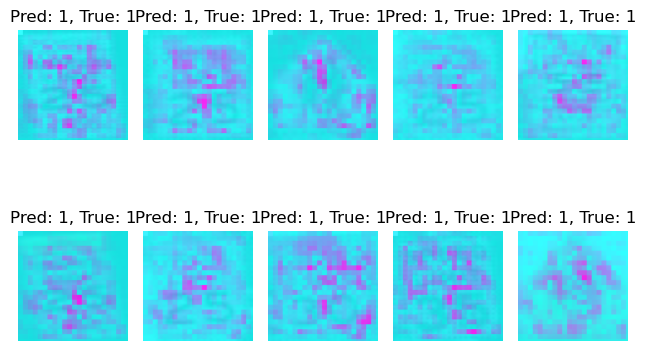

In [48]:
occlusion_map(model, loader_predictions11, device, )